# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [ ]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [7]:
import math
import os
import tempfile
import torch

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, load_dataset
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [17]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_PATH = "/dccstor/tsfm-irl/vijaye12/hacking/models/new/vj_ttm_512_96_e20_ms-20250703-1318-1/vj_ttm_512_96_e20_ms-20250703-1318-1/models/checkpoints/checkpoint-203048"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96


dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

DATA_ROOT_PATH = "/dccstor/tsfm23/datasets/"
# Results dir
OUT_DIR = "ttm_finetuned_models/"

In [30]:
TARGET_DATASET = "etth2"


# Data processing

In [4]:
# # Dataset
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
# timestamp_column = "date"
# id_columns = []  # mention the ids that uniquely identify a time-series.

# target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
# split_config = {
#     "train": [0, 8640],
#     "valid": [8640, 11520],
#     "test": [
#         11520,
#         14400,
#     ],
# }
# # Understanding the split config -- slides

# data = pd.read_csv(
#     dataset_path,
#     parse_dates=[timestamp_column],
# )

# column_specifiers = {
#     "timestamp_column": timestamp_column,
#     "id_columns": id_columns,
#     "target_columns": target_columns,
#     "control_columns": [],
# }

## Zero-shot evaluation method

In [31]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    _, _, dset_test = load_dataset(
            TARGET_DATASET,
            CONTEXT_LENGTH,
            PREDICTION_LENGTH,
            dataset_root_path=DATA_ROOT_PATH,
            use_frequency_token=False,
            enable_padding=False,
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-130580:t-22889113862848:get_model.py:get_model:Loading model from: /dccstor/tsfm-irl/vijaye12/hacking/models/new/vj_ttm_512_96_e20_ms-20250703-1318-1/vj_ttm_512_96_e20_ms-20250703-1318-1/models/checkpoints/checkpoint-203048
INFO:p-130580:t-22889113862848:get_model.py:get_model:Model loaded successfully from /dccstor/tsfm-irl/vijaye12/hacking/models/new/vj_ttm_512_96_e20_ms-20250703-1318-1/vj_ttm_512_96_e20_ms-20250703-1318-1/models/checkpoints/checkpoint-203048, revision = None.
INFO:p-130580:t-22889113862848:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
INFO:p-130580:t-22889113862848:data_handling.py:load_dataset:Dataset name: etth2, context length: 512, prediction length 96
INFO:p-130580:t-22889113862848:data_handling.py:load_dataset:Data lengths: train = 8033, val = 2785, test = 2785


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.2819461226463318, 'eval_model_preparation_time': 0.0024, 'eval_runtime': 1.0398, 'eval_samples_per_second': 2678.321, 'eval_steps_per_second': 42.315}
(2785, 96, 7)
(2785, 7, 134, 24)


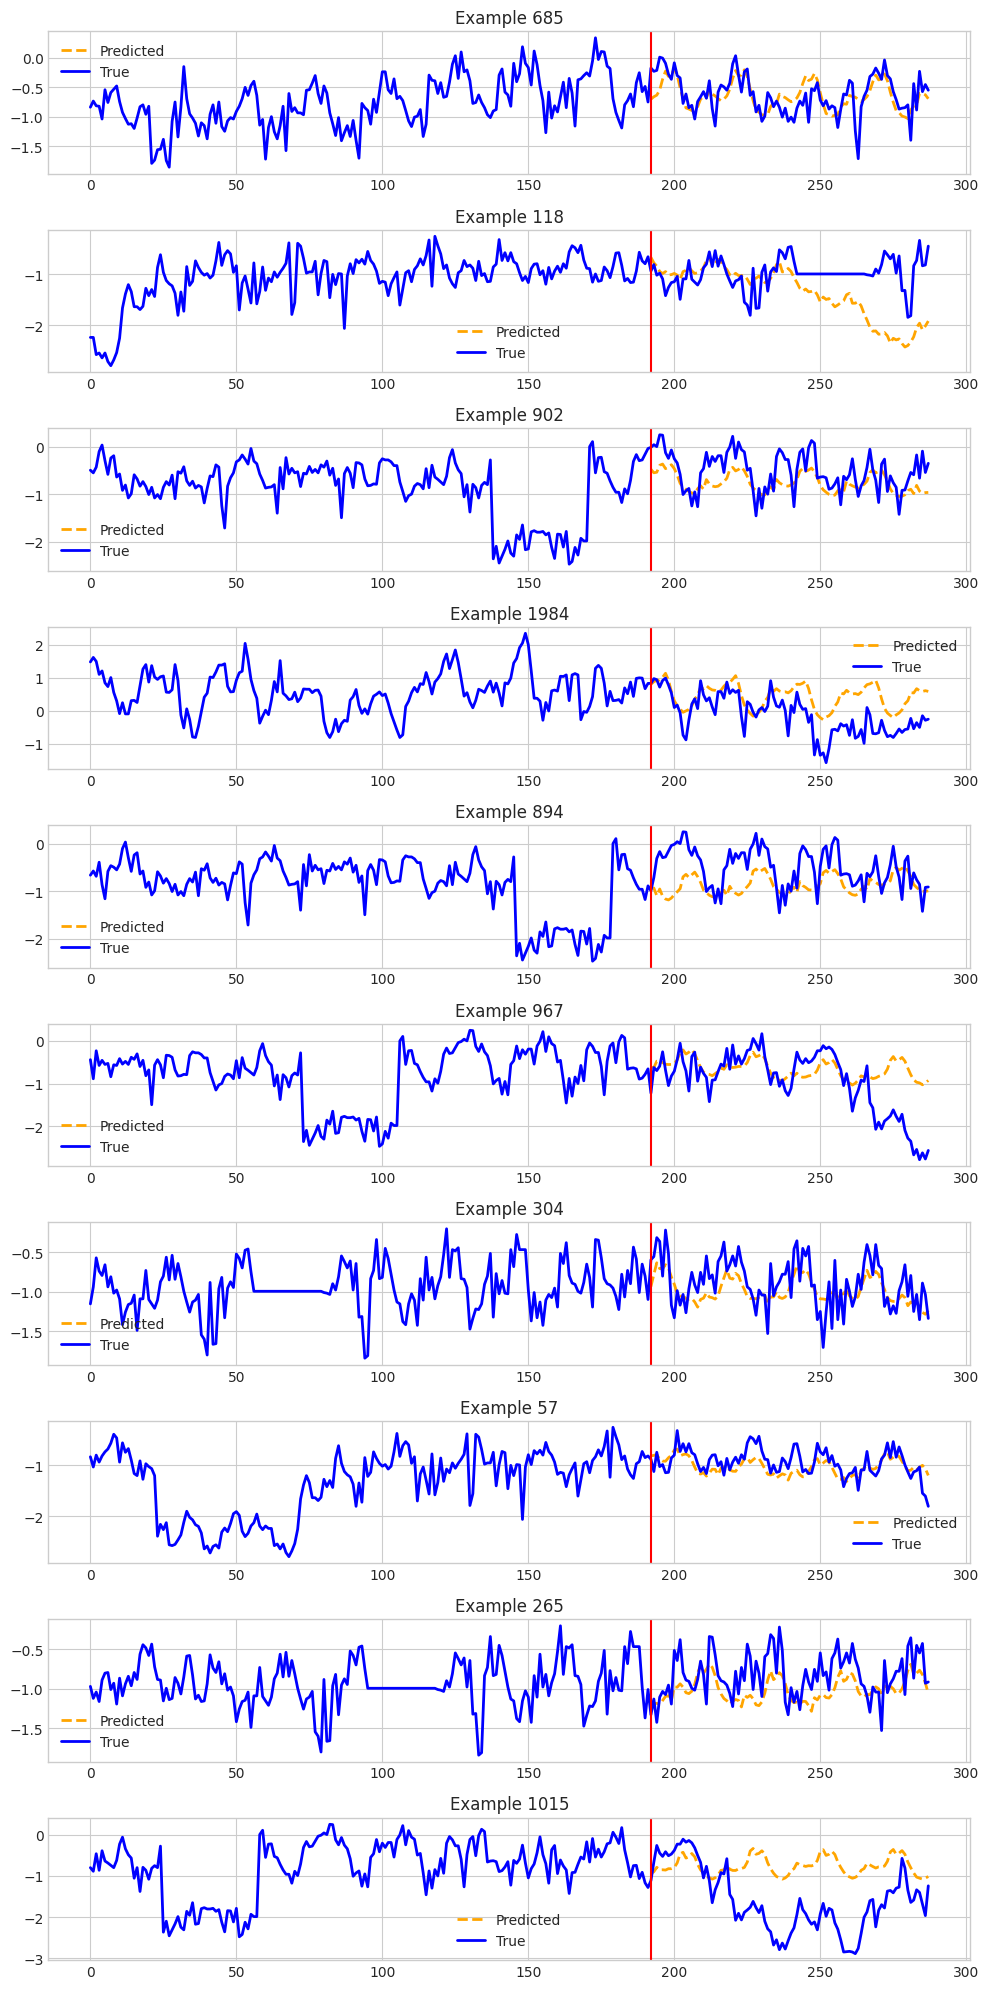

In [32]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [51]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    # tsp = TimeSeriesPreprocessor(
    #     **column_specifiers,
    #     context_length=context_length,
    #     prediction_length=forecast_length,
    #     scaling=True,
    #     encode_categorical=False,
    #     scaler_type="standard",
    # )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )


    dset_train, dset_val, dset_test = load_dataset(
        TARGET_DATASET,
        CONTEXT_LENGTH,
        PREDICTION_LENGTH,
        dataset_root_path=DATA_ROOT_PATH,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
    )

    for param in finetune_forecast_model.backbone.parameters():
        param.requires_grad = False

    print(finetune_forecast_model)

    # for param in finetune_forecast_model.backbone.encoder.add_tokens.parameters():
    #     param.requires_grad = True
        
    # inject_lora_decoder_and_head(finetune_forecast_model, rank=4)


    # Count params
    print(
        "Number of params after freezing the backbone",
        count_parameters(finetune_forecast_model),
    )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])
    
    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

INFO:p-130580:t-22889113862848:get_model.py:get_model:Loading model from: /dccstor/tsfm-irl/vijaye12/hacking/models/new/vj_ttm_512_96_e20_ms-20250703-1318-1/vj_ttm_512_96_e20_ms-20250703-1318-1/models/checkpoints/checkpoint-203048
INFO:p-130580:t-22889113862848:get_model.py:get_model:Model loaded successfully from /dccstor/tsfm-irl/vijaye12/hacking/models/new/vj_ttm_512_96_e20_ms-20250703-1318-1/vj_ttm_512_96_e20_ms-20250703-1318-1/models/checkpoints/checkpoint-203048, revision = None.
INFO:p-130580:t-22889113862848:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
INFO:p-130580:t-22889113862848:data_handling.py:load_dataset:Dataset name: etth2, context length: 512, prediction length 96
INFO:p-130580:t-22889113862848:data_handling.py:load_dataset:Data lengths: train = 311, val = 2785, test = 2785


-------------------- Running few-shot 5% --------------------
TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): MultiScaleFromPatchedSequence(
        (projectors): ModuleList(
          (0-6): 7 x Linear(in_features=8, out_features=24, bias=True)
        )
      )
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0-9): 10 x TinyTimeMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): TinyTimeMixerNormLayer(
                (norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): TinyTimeMixerMLP(
                (fc1): Linear(in_features=134, out_features=268, bias=True)
                (dropout1): Dropout(p=0.3, inplace=False)
                (fc2): Linear(in_features=268, out_features=134, bias=True)
                (dropout2): Dropout(p=0.3, inplace=False)
              )
              (gating_block): TinyTimeMixer

Epoch,Training Loss,Validation Loss
1,0.385500,0.216814
2,0.349300,0.219390
3,0.302100,0.223819
4,0.274800,0.230859
5,0.250900,0.236609
6,0.219700,0.239716
7,0.190600,0.243079
8,0.172800,0.250634
9,0.155600,0.261313
10,0.144100,0.267673


[TrackingCallback] Mean Epoch Time = 0.4632722030986439 seconds, Total Train Time = 17.169149160385132
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2792547047138214, 'eval_runtime': 1.0517, 'eval_samples_per_second': 2648.139, 'eval_steps_per_second': 41.838, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 134, 24)


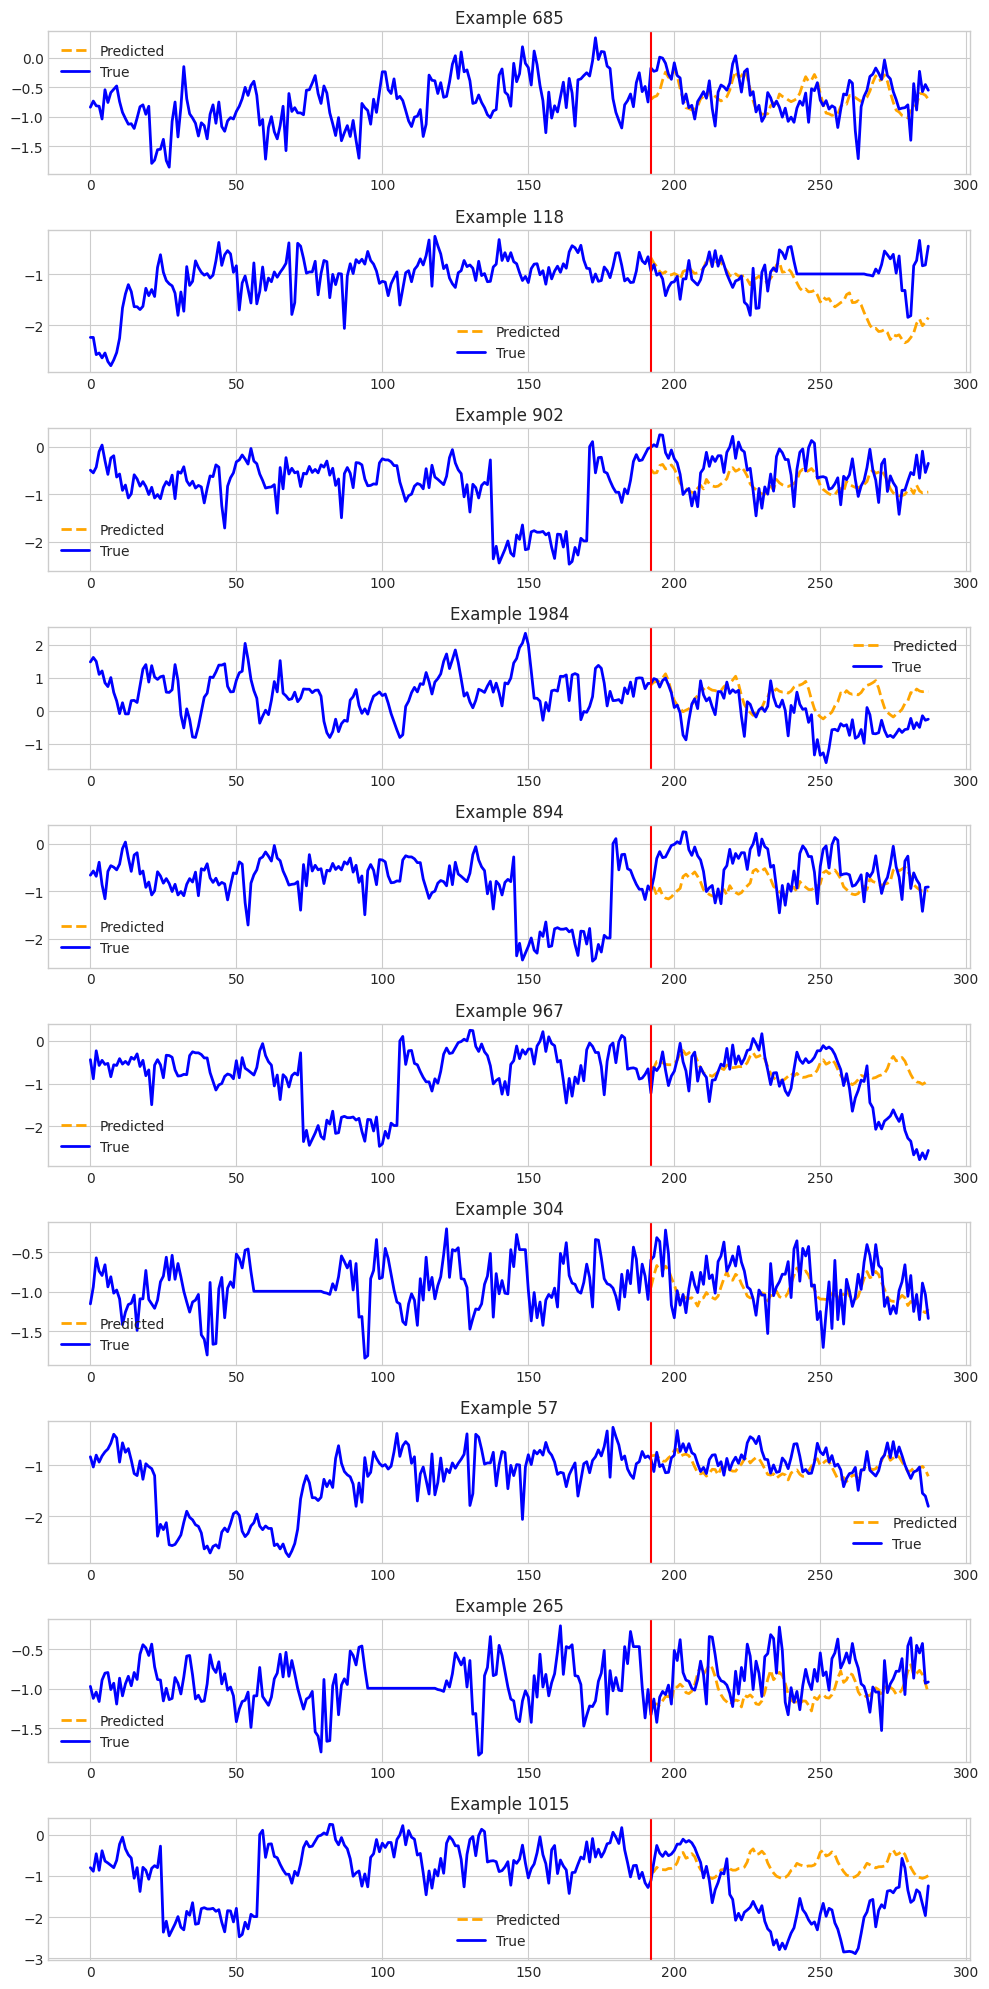

In [52]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.327900,0.273010
2,0.324500,0.272937
3,0.317400,0.272860
4,0.311000,0.272869
5,0.309400,0.273278
6,0.305200,0.274445
7,0.297900,0.276200
8,0.291600,0.279156
9,0.288500,0.283543
10,0.286300,0.286393


[TrackingCallback] Mean Epoch Time = 0.561025069310115 seconds, Total Train Time = 17.760613679885864
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36178672313690186, 'eval_runtime': 0.7961, 'eval_samples_per_second': 3498.122, 'eval_steps_per_second': 55.267, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


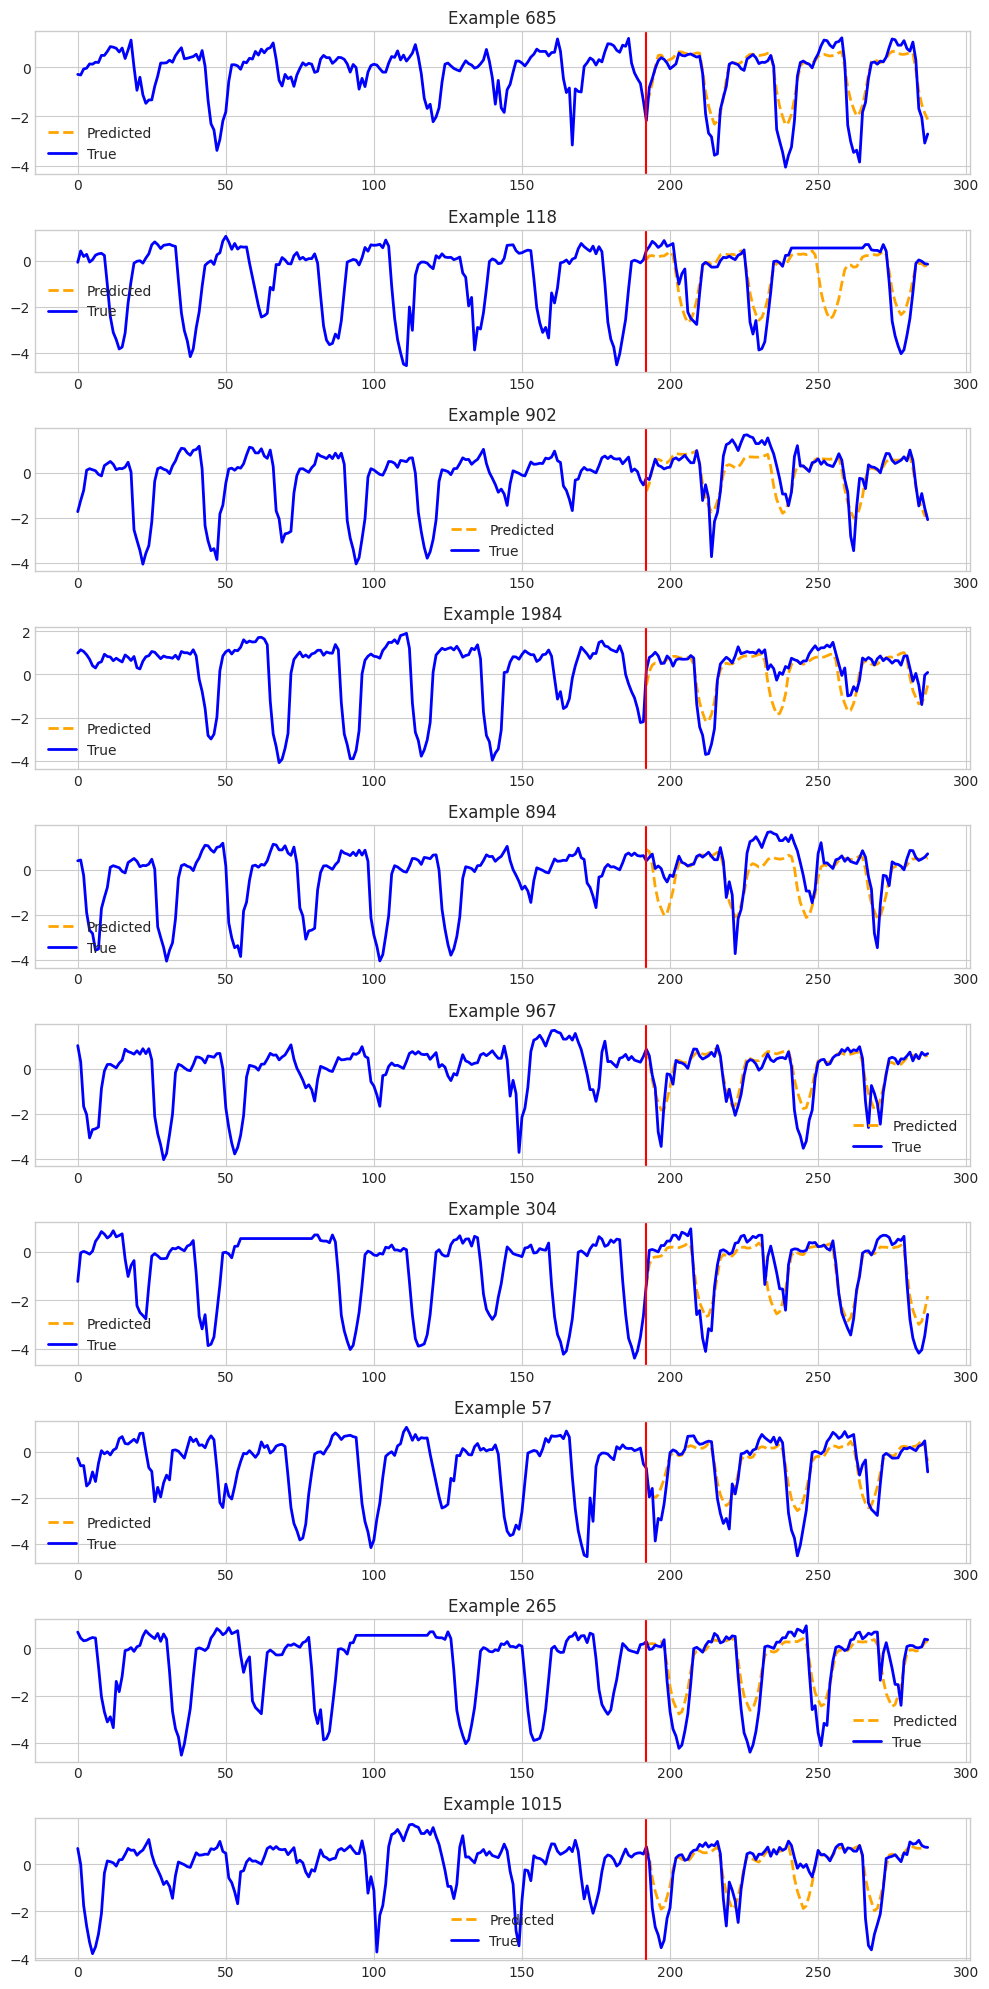

In [10]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.33274462819099426, 'eval_model_preparation_time': 0.0017, 'eval_runtime': 0.899, 'eval_samples_per_second': 3151.371, 'eval_steps_per_second': 50.057}
(2833, 48, 7)
(2833, 7, 8, 384)


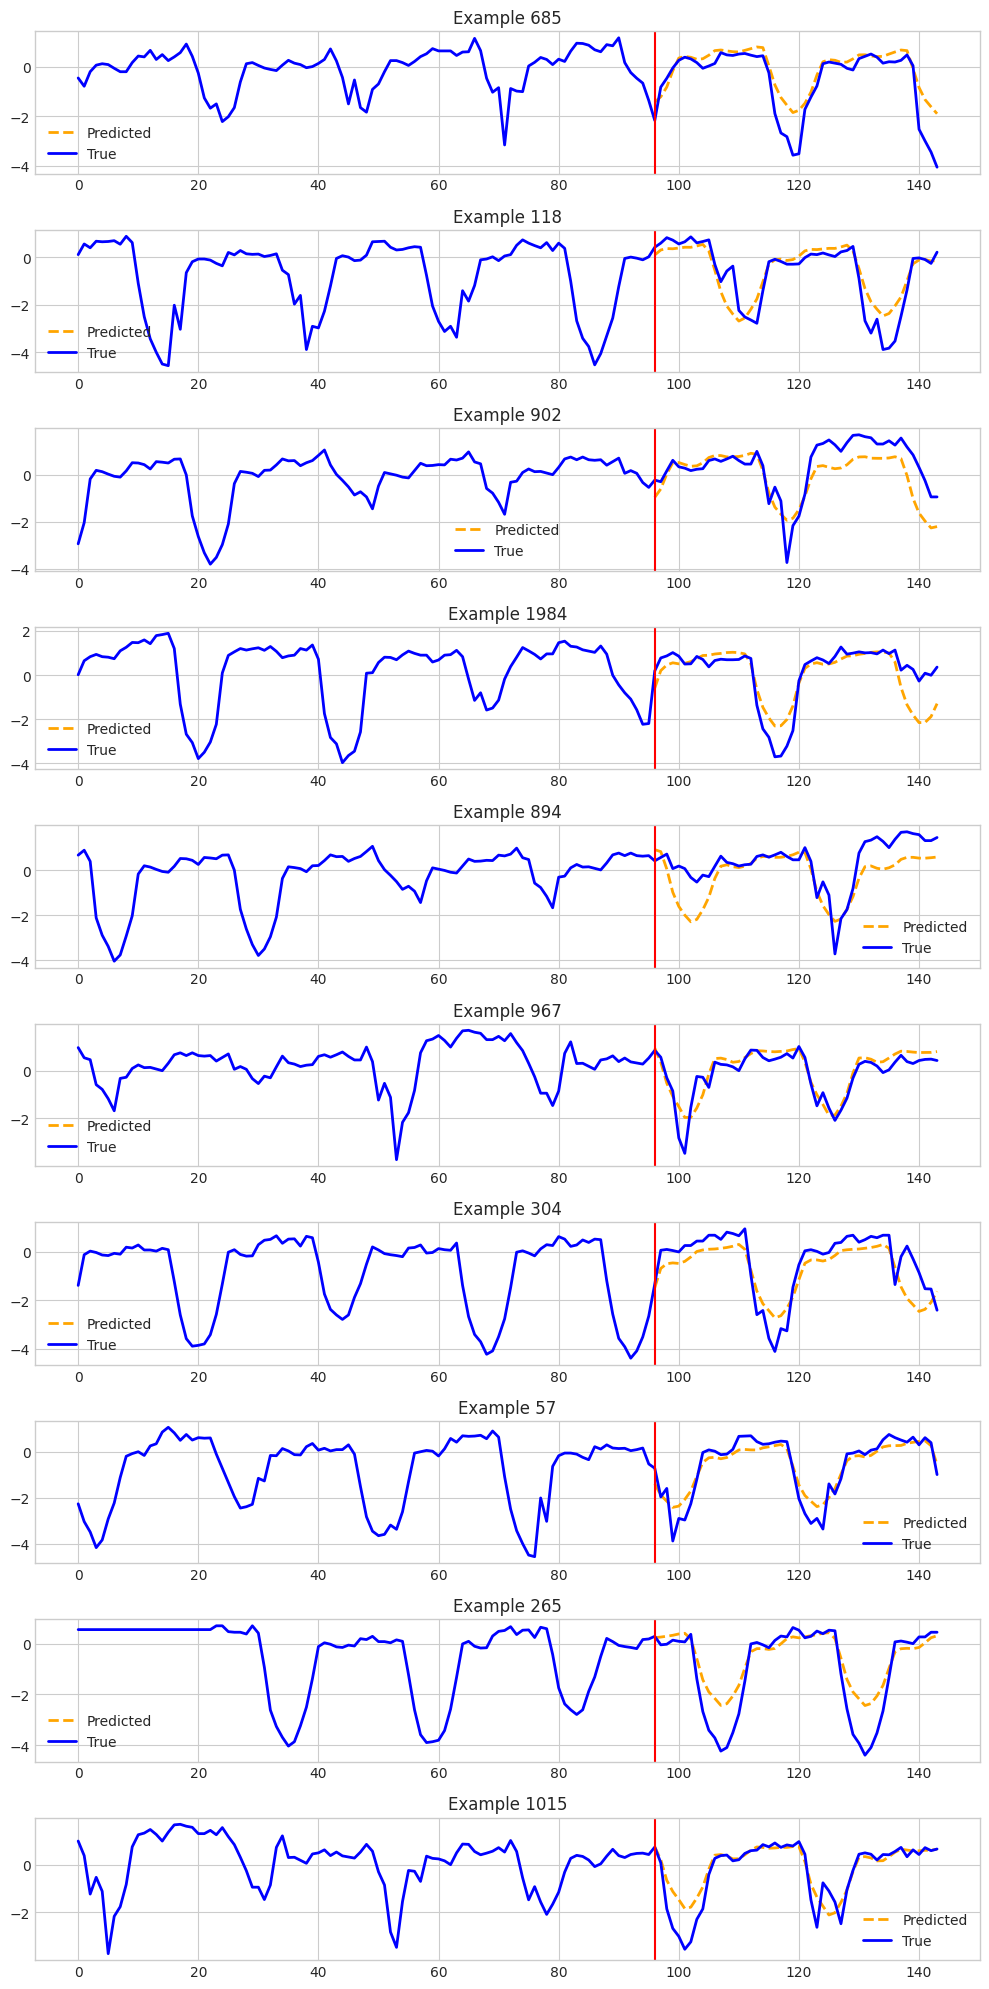

In [11]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96
INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.


-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560


INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.00035938136638046257


OPTIMAL SUGGESTED LEARNING RATE = 0.00035938136638046257
Using learning rate = 0.00035938136638046257


Epoch,Training Loss,Validation Loss
1,0.558300,0.504625
2,0.522800,0.505693
3,0.492200,0.506962
4,0.483700,0.508520
5,0.397600,0.510497
6,0.323300,0.514045
7,0.345200,0.525361
8,0.280800,0.541318
9,0.238600,0.550981
10,0.221500,0.592485


[TrackingCallback] Mean Epoch Time = 0.5700289119373668 seconds, Total Train Time = 17.286776304244995
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.32994186878204346, 'eval_runtime': 0.9431, 'eval_samples_per_second': 3003.961, 'eval_steps_per_second': 47.716, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2833, 48, 7)
(2833, 7, 12, 384)


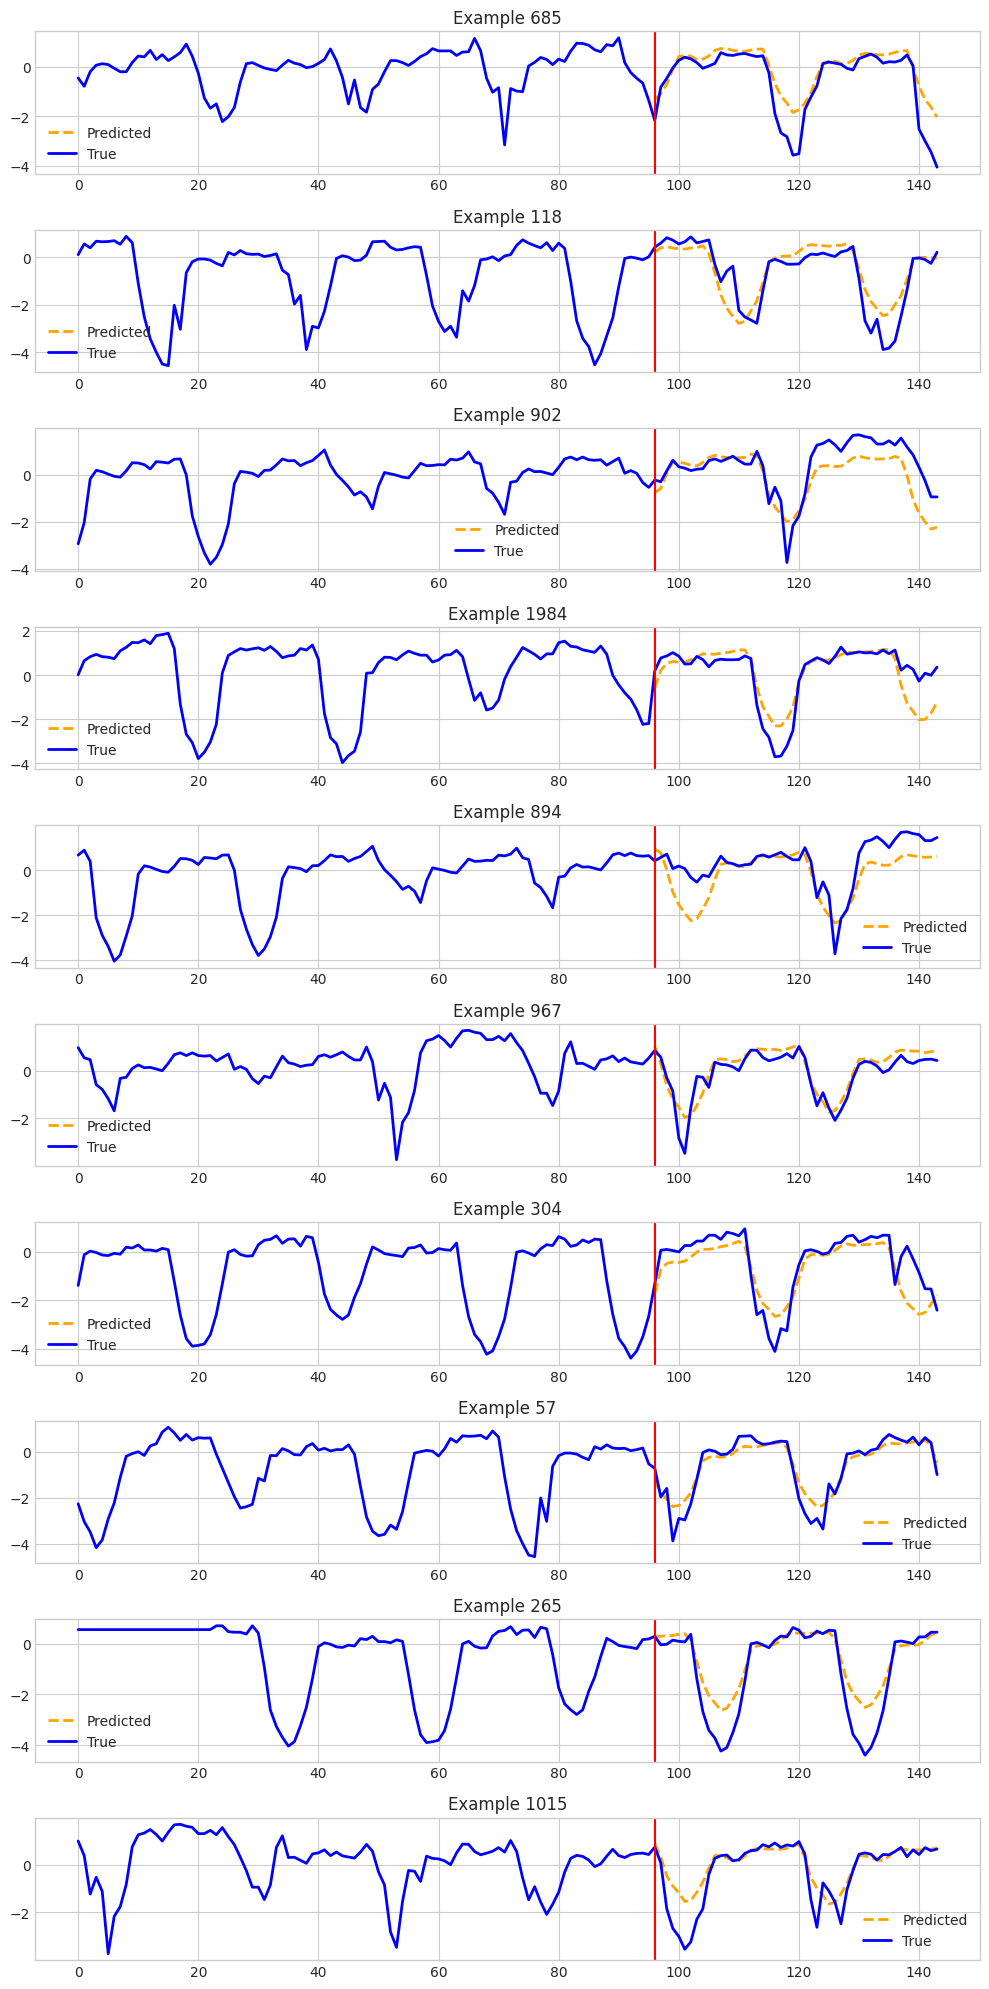

In [12]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)